In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_05/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.13839% 	9.12373% 	0.04888		0.04716		0.0		1.0	
(1024,256) 	95.4% 		0.47362% 	6.41948% 	0.82382		0.80488		0.0		0.96573	
(1024,1024) 	3.04% 		1.9141% 	2.40134% 	0.02452		0.00411		0.0		0.74356	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(99200, 1.0) 1.00000 1.00000 0.00000 	(209717, 0.8569848342924622) 0.84980 0.85698 0.00718 	(5293, 0.9823321554770318) 0.29806 0.98233 0.68427 	
(30861, 1.0) 1.00000 1.00000 0.00000 	(187403, 0.8082255990285311) 0.82183 0.80823 0.01360 	(586879, 0.9493521790341579) 0.04743 0.94935 0.90192 	
(9101, 1.0) 0.99521 1.00000 0.00479 	(183628, 0.8634086972953426) 0.80409 0.86341 0.05932 	(146491, 0.3085983510011779) 0.13357 0.30860 0.17503 	
(1927, 1.0) 0.32576 1.00000 0.67424 	(50332, 0.8519743330122854) 0.84849 0.85197 0.00348 	(140880, 1.0) 0.04306 1.00000 0.95694 	
(2053, 1.0) 0.86471 1.00000 0.13529 	(30202, 0.7892230306589061) 0.84886 0.78922 0.05964 	(237579, 0.9811542991755006) 0.29530 0.98115 0.68585 	
(42117, 1.0) 0.99998 1.00000 0.00002 	(234124, 0.8739351063513874) 0.86533 0.87394 0.00861 	(342504, 0.9340400471142521) 0.08798

(21117, 1.0) 1.00000 1.00000 0.00000 	(153952, 0.8389917030949567) 0.84588 0.83899 0.00689 	(143420, 0.8833922261484101) 0.13020 0.88339 0.75320 	
(75011, 1.0) 1.00000 1.00000 0.00000 	(61729, 0.8359272254254795) 0.84726 0.83593 0.01134 	(184533, 0.9305064782096585) 0.08918 0.93051 0.84133 	
(2190, 1.0) 0.88718 1.00000 0.11282 	(101682, 0.9133245145330057) 0.87139 0.91332 0.04194 	(378127, 0.8374558303886925) 0.09550 0.83746 0.74196 	
(60845, 1.0) 1.00000 1.00000 0.00000 	(167256, 0.8343586424064832) 0.85554 0.83436 0.02118 	(10555, 0.4475853945818611) 0.08016 0.44759 0.36743 	
(83714, 1.0) 1.00000 1.00000 0.00000 	(135250, 0.8716531538498025) 0.84790 0.87165 0.02375 	(157921, 0.9093050647820966) 0.10938 0.90931 0.79993 	
(56204, 1.0) 0.99886 1.00000 0.00114 	(137735, 0.8113653345628378) 0.84791 0.81137 0.03654 	(662629, 0.9976442873969376) 0.03459 0.99764 0.96305 	
(53897, 1.0) 1.00000 1.00000 0.00000 	(108315, 0.8310610215340777) 0.85558 0.83106 0.02452 	(63542, 0.9787985865724382) 0

(48000, 1.0) 1.00000 1.00000 0.00000 	(132443, 0.870932636128764) 0.87440 0.87093 0.00347 	(35204, 0.9093050647820966) 0.11805 0.90931 0.79126 	
(72456, 1.0) 1.00000 1.00000 0.00000 	(247098, 0.8604355125348365) 0.86533 0.86044 0.00489 	(82029, 0.4511189634864547) 0.23032 0.45112 0.22080 	
(48522, 1.0) 0.99890 1.00000 0.00110 	(76717, 0.9104007001498311) 0.84503 0.91040 0.06537 	(38081, 0.7891637220259129) 0.13239 0.78916 0.65677 	
(62082, 1.0) 1.00000 1.00000 0.00000 	(94240, 0.863462665590407) 0.84884 0.86346 0.01463 	(434294, 0.6678445229681979) 0.07669 0.66784 0.59116 	
(47872, 1.0) 0.99887 1.00000 0.00113 	(206960, 0.8528803321609025) 0.84233 0.85288 0.01055 	(284072, 0.607773851590106) 0.13778 0.60777 0.47000 	
(20606, 1.0) 0.99997 1.00000 0.00003 	(111594, 0.8643773237509674) 0.84887 0.86438 0.01551 	(28881, 0.497055359246172) 0.16462 0.49706 0.33243 	
(35347, 1.0) 0.98936 1.00000 0.01064 	(223598, 0.9041404806567276) 0.86531 0.90414 0.03883 	(692298, 0.11778563015312142) 0.0200

(56192, 1.0) 0.99951 1.00000 0.00049 	(25767, 0.8900578536127469) 0.81145 0.89006 0.07861 	(60821, 0.9988221436984688) 0.17085 0.99882 0.82797 	
(63872, 1.0) 1.00000 1.00000 0.00000 	(233413, 0.8721343868163238) 0.86533 0.87213 0.00681 	(119443, 0.8763250883392227) 0.07371 0.87633 0.80261 	
(1191, 1.0) 0.18552 1.00000 0.81448 	(63653, 0.8244673271782752) 0.83395 0.82447 0.00948 	(390533, 0.9976442873969376) 0.12158 0.99764 0.87607 	
(3203, 1.0) 0.92139 1.00000 0.07861 	(27532, 0.7747622368187594) 0.81098 0.77476 0.03621 	(418034, 0.9988221436984688) 0.06562 0.99882 0.93320 	
(24444, 1.0) 0.99938 1.00000 0.00062 	(144868, 0.8452704821310458) 0.84223 0.84527 0.00304 	(9224, 0.8492343934040048) 0.35999 0.84923 0.48924 	
(29703, 1.0) 1.00000 1.00000 0.00000 	(210683, 0.8826438744448695) 0.85796 0.88264 0.02468 	(21700, 0.7149587750294465) 0.20291 0.71496 0.51205 	
(16918, 1.0) 1.00000 1.00000 0.00000 	(63580, 0.8605596650056891) 0.84631 0.86056 0.01425 	(47170, 0.977620730270907) 0.23032 0

(381, 1.0) 0.62001 1.00000 0.37999 	(28930, 0.9075560587617808) 0.67544 0.90756 0.23211 	(17053, 0.8621908127208481) 0.17226 0.86219 0.68993 	
(16674, 1.0) 0.99999 1.00000 0.00001 	(51450, 0.7893719794547808) 0.83503 0.78937 0.04566 	(58606, 0.8433451118963486) 0.09721 0.84335 0.74613 	
(27262, 1.0) 1.00000 1.00000 0.00000 	(61455, 0.8023349987847307) 0.81831 0.80233 0.01598 	(438037, 0.7844522968197879) 0.02127 0.78445 0.76318 	
(121601, 1.0) 1.00000 1.00000 0.00000 	(214972, 0.887819198861293) 0.87114 0.88782 0.01668 	(503994, 1.0) 0.03981 1.00000 0.96019 	
(11135, 1.0) 1.00000 1.00000 0.00000 	(154133, 0.8249307151543948) 0.82653 0.82493 0.00160 	(195687, 0.9316843345111897) 0.15710 0.93168 0.77458 	
(74244, 1.0) 1.00000 1.00000 0.00000 	(194657, 0.8606865966788532) 0.86450 0.86069 0.00381 	(504977, 0.9493521790341579) 0.17384 0.94935 0.77551 	
(19352, 1.0) 0.99917 1.00000 0.00083 	(45761, 0.9347027913142957) 0.85101 0.93470 0.08370 	(61792, 0.9363957597173145) 0.06817 0.93640 0.868

(23323, 1.0) 1.00000 1.00000 0.00000 	(165603, 0.9043120276600733) 0.86655 0.90431 0.03776 	(84522, 0.9458186101295644) 0.65605 0.94582 0.28977 	
(27524, 1.0) 0.95241 1.00000 0.04759 	(107981, 0.8929221672299444) 0.85176 0.89292 0.04116 	(419295, 0.92226148409894) 0.05020 0.92226 0.87206 	
(49532, 1.0) 1.00000 1.00000 0.00000 	(149428, 0.9346097655402978) 0.87872 0.93461 0.05589 	(18447, 0.7479387514723204) 0.36701 0.74794 0.38093 	
(3607, 1.0) 0.98847 1.00000 0.01153 	(99164, 0.8628253957989034) 0.85231 0.86283 0.01052 	(645812, 0.790341578327444) 0.03636 0.79034 0.75398 	
(55187, 1.0) 0.99853 1.00000 0.00147 	(231427, 0.8684305822877106) 0.85196 0.86843 0.01647 	(243818, 0.7338044758539458) 0.08018 0.73380 0.65362 	
(37799, 1.0) 0.99070 1.00000 0.00930 	(125592, 0.8735351235258421) 0.86048 0.87354 0.01306 	(688324, 0.9988221436984688) 0.03599 0.99882 0.96284 	
(48638, 1.0) 1.00000 1.00000 0.00000 	(179995, 0.8476879876235057) 0.85110 0.84769 0.00341 	(22988, 0.9623085983510011) 0.099

(21507, 1.0) 1.00000 1.00000 0.00000 	(196083, 0.871486603934044) 0.85901 0.87149 0.01248 	(25745, 0.9246171967020024) 0.27114 0.92462 0.65348 	
(106112, 1.0) 1.00000 1.00000 0.00000 	(46718, 0.7760743680661347) 0.84449 0.77607 0.06842 	(21623, 0.9328621908127209) 0.29619 0.93286 0.63667 	
(40321, 1.0) 1.00000 1.00000 0.00000 	(11939, 0.8812724752699311) 0.86406 0.88127 0.01721 	(32192, 0.9069493521790342) 0.11298 0.90695 0.79397 	
(23291, 1.0) 1.00000 1.00000 0.00000 	(95278, 0.8703637799655697) 0.85221 0.87036 0.01816 	(219194, 0.8091872791519437) 0.12695 0.80919 0.68224 	
(90371, 1.0) 0.99999 1.00000 0.00001 	(128313, 0.827936539498178) 0.81646 0.82794 0.01147 	(23939, 0.6489988221436985) 0.14812 0.64900 0.50088 	
(70144, 1.0) 1.00000 1.00000 0.00000 	(126558, 0.877114901605281) 0.84432 0.87711 0.03279 	(455465, 0.917550058892815) 0.00993 0.91755 0.90762 	
(4748, 1.0) 0.85057 1.00000 0.14943 	(181660, 0.8489272123419432) 0.85659 0.84893 0.00766 	(435253, 1.0) 0.11654 1.00000 0.88346

(17028, 1.0) 1.00000 1.00000 0.00000 	(248012, 0.8821546032580995) 0.86533 0.88215 0.01683 	(292259, 0.8857479387514724) 0.05216 0.88575 0.83359 	
(49793, 1.0) 1.00000 1.00000 0.00000 	(260954, 0.8282381671886918) 0.77633 0.82824 0.05191 	(560548, 0.9199057714958776) 0.04031 0.91991 0.87960 	
(68224, 1.0) 1.00000 1.00000 0.00000 	(250712, 0.8919922247236901) 0.86517 0.89199 0.02682 	(285716, 0.8751472320376915) 0.13647 0.87515 0.73867 	
(76548, 1.0) 1.00000 1.00000 0.00000 	(235358, 0.8862918021138759) 0.86533 0.88629 0.02096 	(100474, 0.5253239104829212) 0.23032 0.52532 0.29501 	
(1408, 1.0) 0.98642 1.00000 0.01358 	(192930, 0.8674452101644674) 0.85940 0.86745 0.00805 	(90441, 0.7302709069493521) 0.05519 0.73027 0.67508 	
(81666, 1.0) 1.00000 1.00000 0.00000 	(138572, 0.9084664476191595) 0.86313 0.90847 0.04533 	(85076, 0.9057714958775029) 0.23032 0.90577 0.67545 	
(10238, 1.0) 1.00000 1.00000 0.00000 	(229931, 0.8671261265014778) 0.86533 0.86713 0.00180 	(285170, 0.9328621908127209) 

(2940, 1.0) 0.99685 1.00000 0.00315 	(87996, 0.7732233447709368) 0.85992 0.77322 0.08670 	(207913, 0.11778563015312142) 0.11557 0.11779 0.00221 	
(23553, 1.0) 0.94406 1.00000 0.05594 	(198802, 0.8574516382963342) 0.84162 0.85745 0.01583 	(28118, 0.9140164899882215) 0.13510 0.91402 0.77891 	
(47102, 1.0) 1.00000 1.00000 0.00000 	(86813, 0.9312678360756813) 0.86289 0.93127 0.06838 	(527488, 0.96113074204947) 0.03245 0.96113 0.92868 	
(58245, 1.0) 0.99942 1.00000 0.00058 	(187416, 0.8261634598830063) 0.83043 0.82616 0.00426 	(690275, 1.0) 0.06718 1.00000 0.93282 	
(74240, 1.0) 1.00000 1.00000 0.00000 	(241766, 0.86338847936463) 0.86521 0.86339 0.00182 	(680436, 0.42520612485276804) 0.06749 0.42521 0.35771 	
(12291, 1.0) 1.00000 1.00000 0.00000 	(231851, 0.867522343911116) 0.86533 0.86752 0.00219 	(161397, 0.9693757361601885) 0.03420 0.96938 0.93518 	
(60418, 1.0) 0.99687 1.00000 0.00313 	(85977, 0.8868094462432815) 0.86045 0.88681 0.02636 	(100485, 0.9352179034157833) 0.22243 0.93522 0.71

(35331, 1.0) 0.95243 1.00000 0.04757 	(249765, 0.8985434326801748) 0.86621 0.89854 0.03233 	(17582, 0.9411071849234394) 0.25477 0.94111 0.68634 	
(1921, 1.0) 0.57730 1.00000 0.42270 	(210278, 0.8718624500624894) 0.85382 0.87186 0.01805 	(3209, 0.26737338044758535) 0.31528 0.26737 0.04790 	
(62348, 1.0) 1.00000 1.00000 0.00000 	(146025, 0.9082016438533872) 0.85097 0.90820 0.05723 	(156205, 0.8869257950530036) 0.04268 0.88693 0.84424 	
(17918, 1.0) 1.00000 1.00000 0.00000 	(246569, 0.8735029240720662) 0.86533 0.87350 0.00817 	(586554, 0.8833922261484101) 0.01045 0.88339 0.87294 	
(39039, 1.0) 1.00000 1.00000 0.00000 	(198069, 0.8547595393039806) 0.86516 0.85476 0.01040 	(78350, 0.7891637220259129) 0.38649 0.78916 0.40267 	
(21787, 1.0) 0.99840 1.00000 0.00160 	(42180, 0.9068522397531507) 0.85913 0.90685 0.04772 	(197800, 0.082449941107185) 0.14968 0.08245 0.06723 	
(42386, 1.0) 1.00000 1.00000 0.00000 	(154928, 0.8119334965588185) 0.81907 0.81193 0.00714 	(86155, 0.9316843345111897) 0.21

(11162, 1.0) 0.99354 1.00000 0.00646 	(108314, 0.817137043826321) 0.85621 0.81714 0.03908 	(696368, 0.9116607773851589) 0.05557 0.91166 0.85609 	
(5509, 1.0) 0.94459 1.00000 0.05541 	(450, 0.7822621958172463) 0.41404 0.78226 0.36822 	(179749, 0.44051825677267376) 0.04825 0.44052 0.39227 	
(81795, 1.0) 1.00000 1.00000 0.00000 	(219477, 0.9219503485346302) 0.87980 0.92195 0.04215 	(595973, 0.9210836277974088) 0.17863 0.92108 0.74246 	
(44569, 1.0) 1.00000 1.00000 0.00000 	(80480, 0.8378788482248462) 0.86199 0.83788 0.02411 	(229633, 0.92226148409894) 0.13654 0.92226 0.78572 	
(39966, 1.0) 0.99565 1.00000 0.00435 	(91077, 0.8884423027689542) 0.87357 0.88844 0.01487 	(390682, 0.7432273262661956) 0.01664 0.74323 0.72659 	
(50850, 1.0) 0.99999 1.00000 0.00001 	(46855, 0.9502290553499871) 0.85872 0.95023 0.09151 	(469002, 0.9505300353356891) 0.08724 0.95053 0.86329 	
(17573, 1.0) 0.99816 1.00000 0.00184 	(254938, 0.8776961319918302) 0.86533 0.87770 0.01237 	(104818, 0.9128386336866903) 0.1483

(4013, 1.0) 0.99930 1.00000 0.00070 	(12188, 0.9048640165302109) 0.83823 0.90486 0.06664 	(3176, 0.5488810365135454) 0.31528 0.54888 0.23361 	
(76544, 1.0) 1.00000 1.00000 0.00000 	(132839, 0.8230286344830318) 0.86638 0.82303 0.04335 	(107072, 0.8857479387514724) 0.01764 0.88575 0.86811 	
(126977, 1.0) 1.00000 1.00000 0.00000 	(121860, 0.8672533695923126) 0.83824 0.86725 0.02901 	(332822, 0.9988221436984688) 0.30500 0.99882 0.69383 	
(54655, 1.0) 1.00000 1.00000 0.00000 	(15848, 0.744392020475491) 0.75102 0.74439 0.00663 	(9702, 0.9540636042402827) 0.14033 0.95406 0.81373 	
(65284, 1.0) 0.99994 1.00000 0.00006 	(186012, 0.8382730702809184) 0.84679 0.83827 0.00852 	(241301, 0.9281507656065962) 0.02222 0.92815 0.90593 	
(21010, 1.0) 1.00000 1.00000 0.00000 	(45224, 0.8693229241601939) 0.86523 0.86932 0.00410 	(333157, 0.8998822143698468) 0.07553 0.89988 0.82435 	
(32380, 1.0) 1.00000 1.00000 0.00000 	(253415, 0.8811985194611678) 0.86533 0.88120 0.01587 	(138310, 0.9316843345111897) 0.106

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


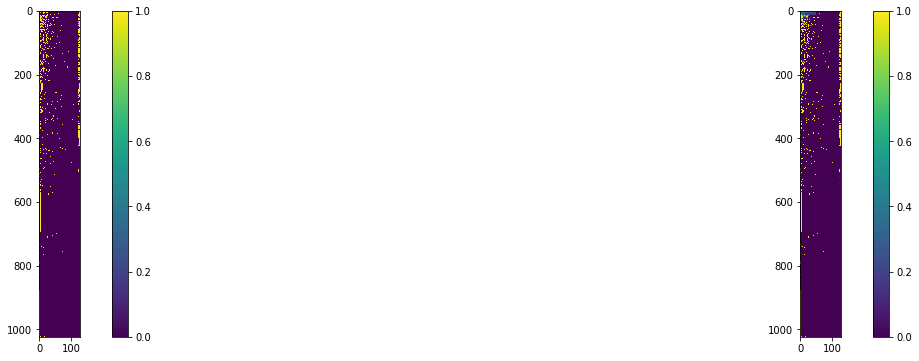

0.0
0.9657312


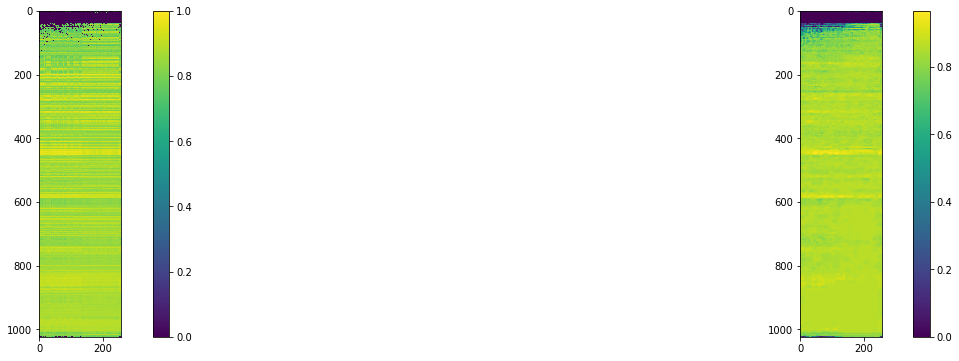

9.107138e-12
0.7435637


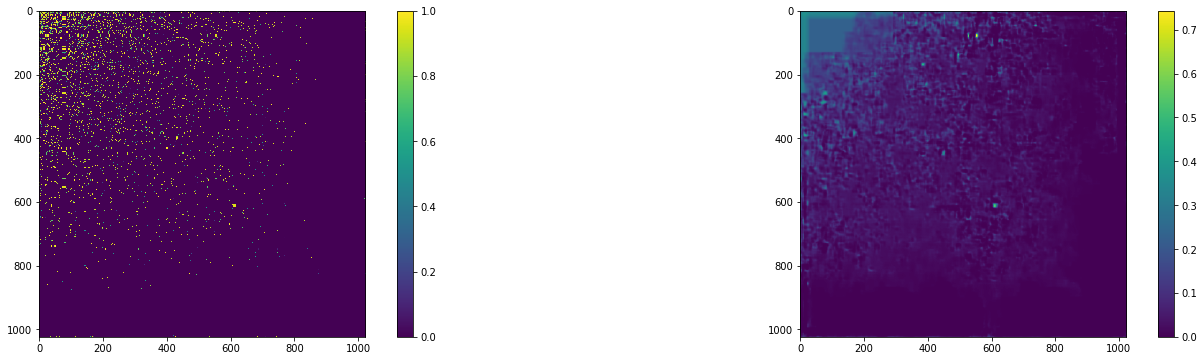

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_05/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
# color_pack2 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

#     ax = axes[2]
#     im = ax.imshow(predict - org_data, vmin=-1, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


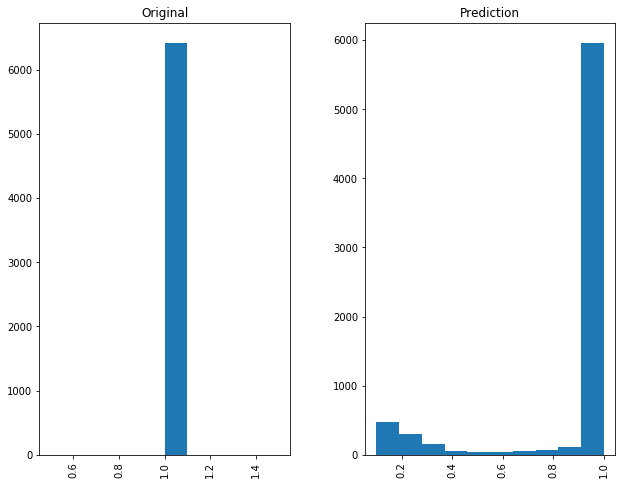

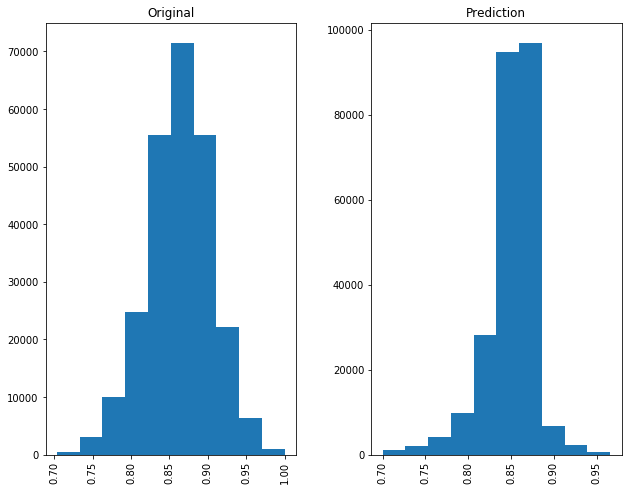

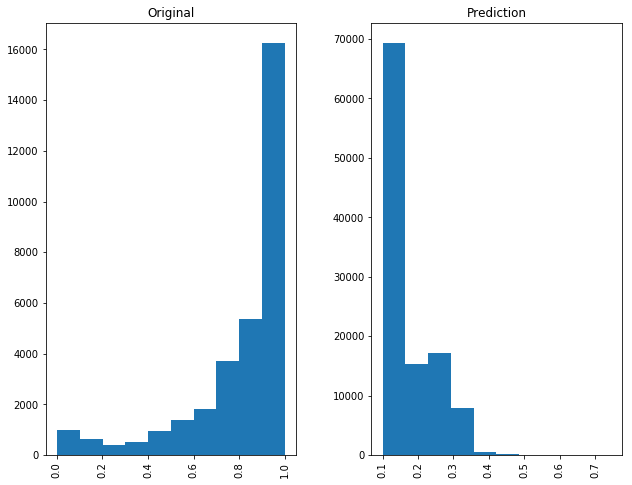

In [6]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'histogram_distribution_' + str(i))
    

/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


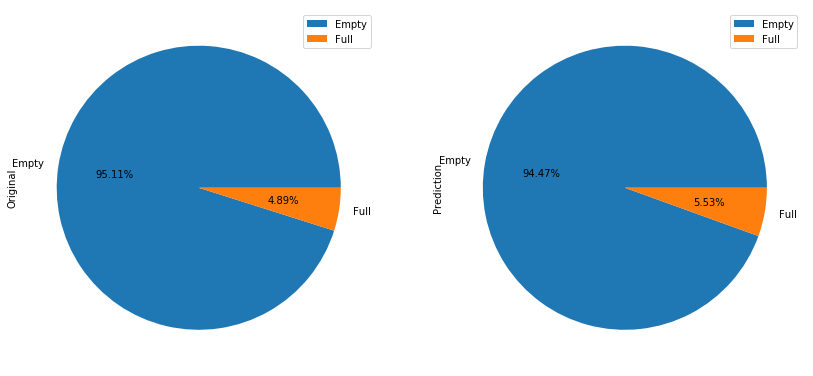

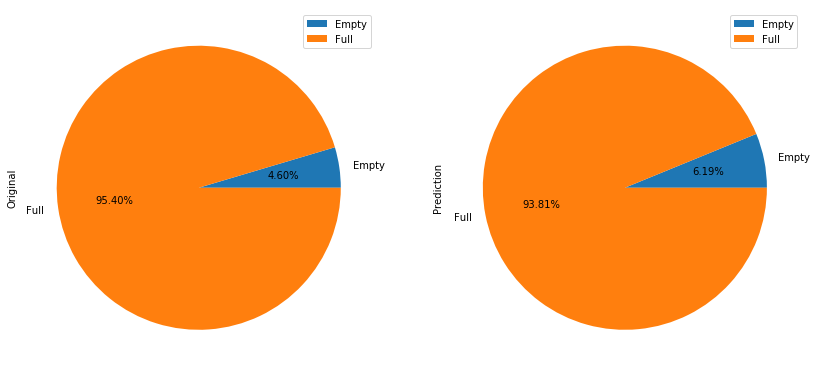

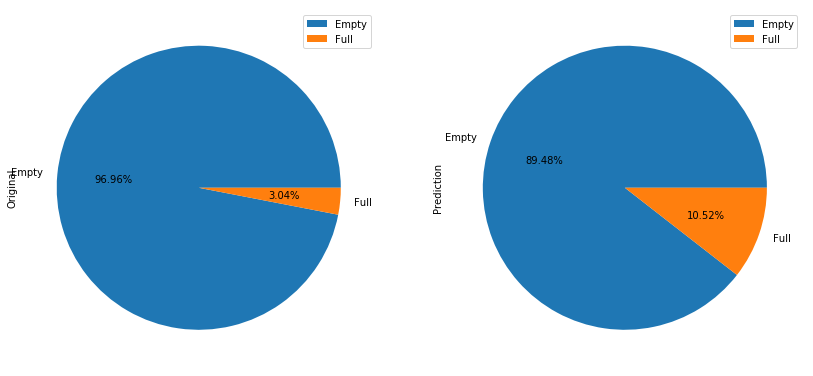

In [7]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    d = {}
    d['Original'] = []
    d['Original'].append(len(org_data[org_data == 0]) / length)
    d['Original'].append(len(org_data[org_data > 0]) / length)

    if i == 1:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.7]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.7]) / length)
    else:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.1]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.1]) / length)

    fig, ax = plt.subplots(figsize=(14,8))
    df = pd.DataFrame(d, index=['Empty', 'Full'])
    df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f%%', ax=ax)
    fig.savefig(path + 'pie_density_' + str(i))

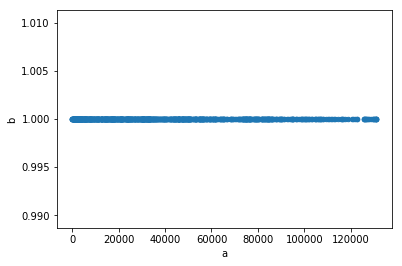

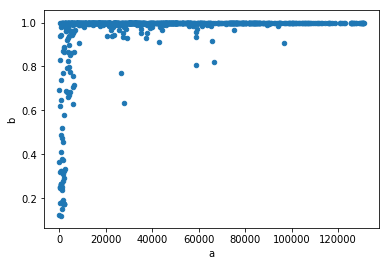

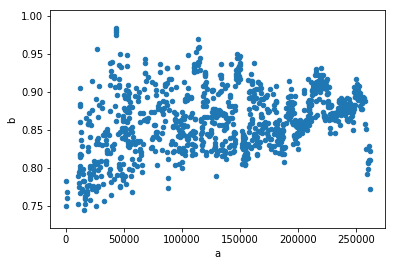

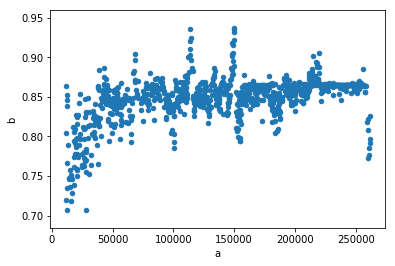

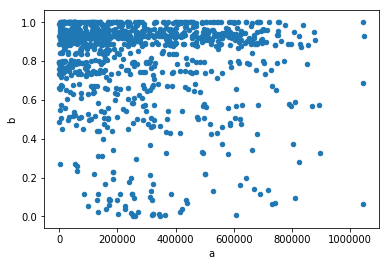

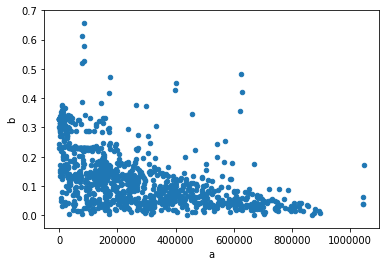

In [8]:
for i in range(len(model.org_data)):
    # df.plot.scatter(x='a', y='b');
    # print(np.random.rand(50, 4))
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    # print(data)
    new_org_data = []
    new_predict_data = []
    for j in range(len(org_data)):
        if i == 1:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            if predict_data[j][1] > 0.7:
                new_predict_data.append([predict_data[j][0], predict_data[j][1]])
        else:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            new_predict_data.append([predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(new_org_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    df = pd.DataFrame(new_predict_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    new_predict_data

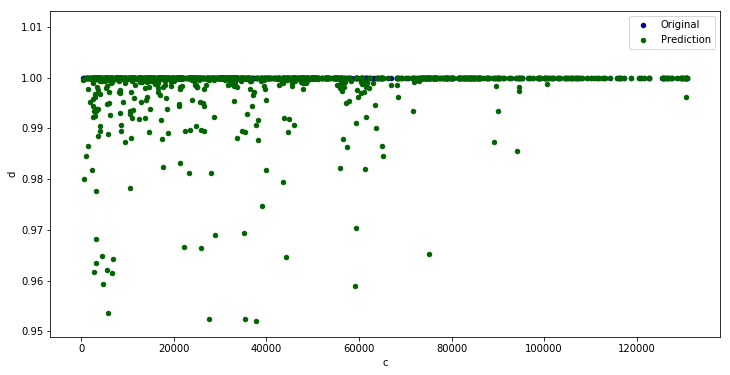

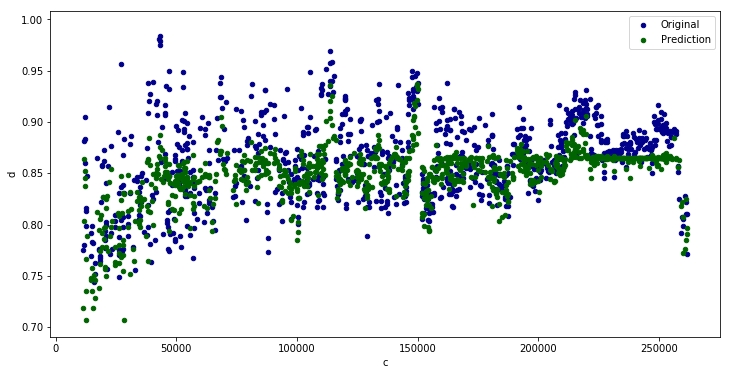

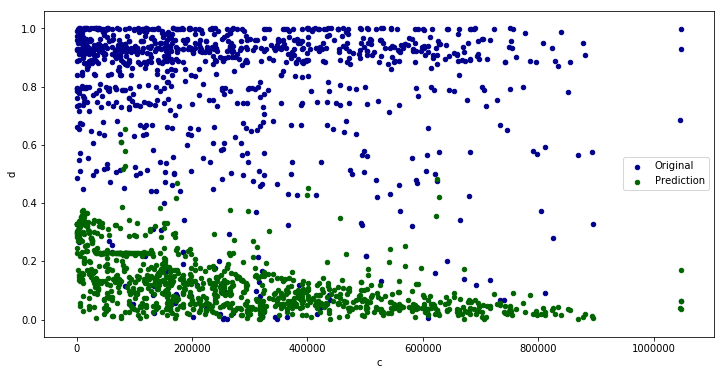

In [9]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

            
    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original');
    df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));

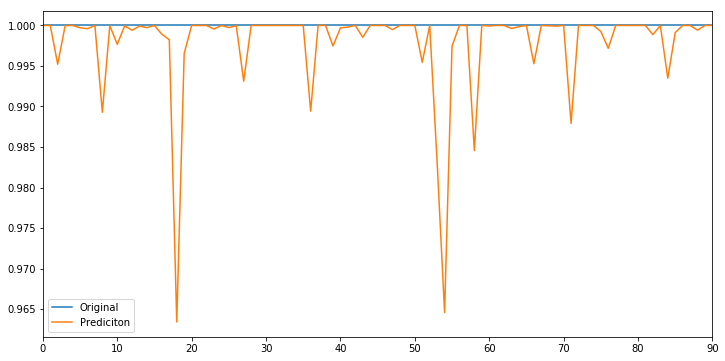

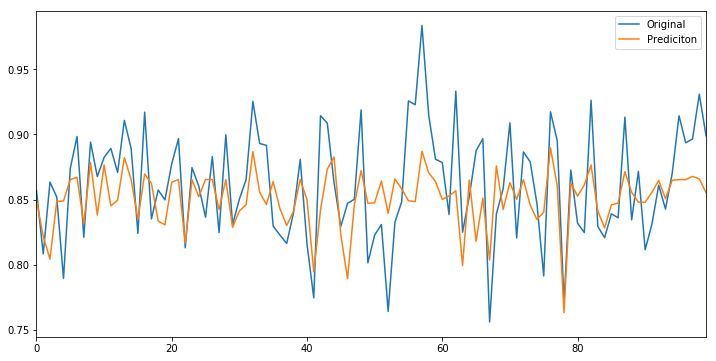

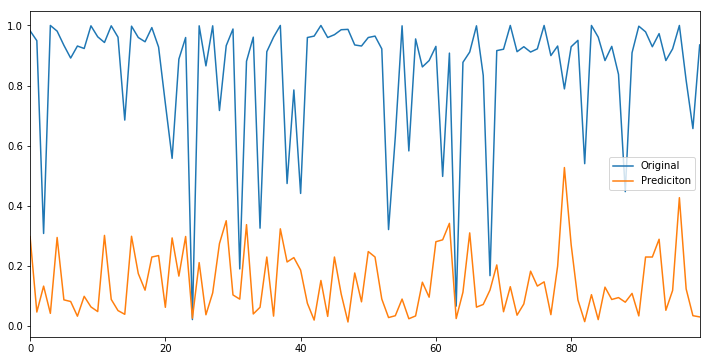

In [10]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[:100])):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][1], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][1], predict_data[j][1]])
        else:
            data.append([org_data[j][1], predict_data[j][1]])

    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(data, columns=['Original', 'Prediciton'])
    df.plot(subplots=False, figsize=(12,6), ax=ax)
    fig.savefig(path + 'graph_org_vs_prediction_' + str(i))